In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp
import pyDOE

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 8) Joint distribution for wind energy with truncated Weibull

Analytical model for testing

In [461]:
def model_poly(WS,sigma_WS,shear):
    # Normalized variables:
    xx = np.array([WS/25., sigma_WS/4.5, (shear+1.5)/3.])
    
    return -((xx[0]-0.1)*(xx[0]-0.8)*(xx[1]-0.5)*(xx[2]-0.4) + (xx[1]-0.2)*(xx[2]-0.2))*(xx[0]-0.9)
    
def model_P(WS,sigma_WS,shear):
    CP = 0.45
    rho = 1.225
    D = 70.
    A = np.pi*D**2/4
    WS_rated = 15.
    P_rated = 3.6e6
    
    TI = sigma_WS/WS
    CP_TI = CP*( 1./(TI+1.) )*( 0.5*special.erf( 3. - (1.*WS/WS_rated) ) + 0.5 )
    WS_eq = WS*( (TI+1.)**3. ) * ( 1. - 0.15*np.cos( shear*np.pi/0.4 ) )
    
    P = CP_TI*0.5*rho*A*(WS_eq)**3.
    return (P/P_rated)*(P<P_rated)*(P>3.) + (1.)*(P>=P_rated) + 0.*(P<=3.)

def ishigami(WS,sigma_WS,shear):
    # Normalized variables:
    xx = 2.*np.pi*np.array([WS/25., sigma_WS/4.5, (shear+1.5)/3.])
    
    # Parameters
    a = 7.
    b = 0.8#0.1
    
    term1 = np.sin(xx[0])
    term2 = a*(np.sin(xx[1]))**2
    term3 = b*xx[2]**4. * np.sin(xx[0])

    return term1 + term2 + term3



def model_G(WS,sigma_WS,shear):

    '''    
    function [y] = gfunc(xx, a)

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %
    % G-FUNCTION
    %
    % Authors: Sonja Surjanovic, Simon Fraser University
    %          Derek Bingham, Simon Fraser University
    % Questions/Comments: Please email Derek Bingham at dbingham@stat.sfu.ca.
    %
    % Copyright 2013. Derek Bingham, Simon Fraser University.
    %
    % THERE IS NO WARRANTY, EXPRESS OR IMPLIED. WE DO NOT ASSUME ANY LIABILITY
    % FOR THE USE OF THIS SOFTWARE.  If software is modified to produce
    % derivative works, such modified software should be clearly marked.
    % Additionally, this program is free software; you can redistribute it 
    % and/or modify it under the terms of the GNU General Public License as 
    % published by the Free Software Foundation; version 2.0 of the License. 
    % Accordingly, this program is distributed in the hope that it will be 
    % useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
    % of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
    % General Public License for more details.
    %
    % For function details and reference information, see:
    % http://www.sfu.ca/~ssurjano/
    %
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %
    % INPUTS:
    %
    % xx = [x1, x2, ..., xd]
    % a = [a1, a2, ..., ad] (optional), with default values given by Crestaux
    %     et al. (2007)
    %
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    d = length(xx);

    if (nargin == 1)
        a = zeros(1, d);
        for ii = 1:d
            a(ii) = (ii-1) / 2;
        end
    end

    prod = 1;
    for ii = 1:d
        xi = xx(ii);
        ai = a(ii);
        new1 = abs(4*xi-2) + ai;
        new2 = 1 + ai;
        prod = prod * new1/new2;
    end

    y = prod;

    end    
    '''    
    
    # Normalized variables:
    xx = [WS/25., sigma_WS/4.5, (shear+1.5)/3.]
    
    # G-FUNCTION parameters:
    # Ws is important, std_WS relatively important and shear is non-important 
    a = [0., 1., 6.]
    
    prod = 1
    for ii in range(3):
        xi = xx[ii]
        ai = a[ii]
        new1 = np.abs(4.*xi-2.) + ai
        new2 = 1. + ai
        prod = prod * new1/new2
    
    return prod



In [520]:
# model_poly 'z' #ishigami 'y' # model_G 'g' #model_P 'P'
model = model_P 
output_name_label = 'P'

Polynomial fit of the normal turbulence model (NTM) [IEC 61400 2015]

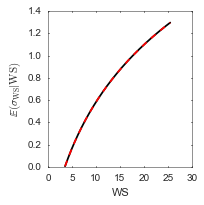

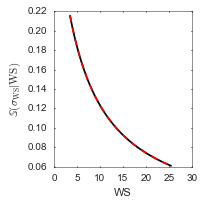

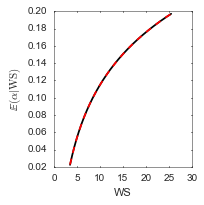

In [521]:
WS_rng = np.linspace(3.5,25.5,1000,endpoint=True)
I_ref = .16
S_sigma = (np.log( 1. + (1.4)**2./(0.75*WS_rng + 3.8)**2.))**0.5
E_sigma = np.log( I_ref*(0.75*WS_rng + 3.8) ) - S_sigma**2./2

E_sigma_pfit = np.poly1d(np.polyfit(WS_rng,E_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,E_sigma,'k')
ax.plot(WS_rng,E_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

S_sigma_pfit = np.poly1d(np.polyfit(WS_rng,S_sigma,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,S_sigma,'k')
ax.plot(WS_rng,S_sigma_pfit(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{S}(\sigma_{\mathrm{WS}}|\mathrm{WS})$')
fig.tight_layout()

mu_shear = 0.088*(np.log(WS_rng)-1.)

E_a = np.poly1d(np.polyfit(WS_rng,mu_shear,6))

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(WS_rng,mu_shear,'k')
ax.plot(WS_rng,E_a(WS_rng),'--r')
ax.set_xlabel('WS')
ax.set_ylabel(r'$\mathbb{E}(\alpha|\mathrm{WS})$')
fig.tight_layout()




### 0) Joint distribution 

In [522]:
Weibull_truncated = cp.construct(
     cdf=lambda self,q,shape,scale,inf,sup: (stats.weibull_min.cdf(q,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale))/\
                                            (stats.weibull_min.cdf(sup,shape,scale=scale)\
                                             -stats.weibull_min.cdf(inf,shape,scale=scale)),
     bnd=lambda self,shape,scale,inf,sup: (inf,sup),
     #pdf=lambda self,q,shape,scale,inf,sup: stats.vonmises.pdf(q,shape,scale=scale),
     #ppf=lambda self,u,shape,scale,inf,sup: stats.vonmises.ppf(u,shape,scale=scale),
     #mom=lambda self,k,shape,scale,inf,sup: stats.vonmises.moment(k,shape,scale=scale),
     defaults=dict(shape=2., scale=1.,inf=3.5,sup=25.5),
     str=lambda self,shape,scale,inf,sup: ("W_tr%s%s%s%s" % (shape, scale,inf,sup)))

In [523]:
#dist_WS = cp.Weibull(shape=2., scale=10./special.gamma(1.+1./2.))
dist_WS = Weibull_truncated(shape=2., scale=10./special.gamma(1.+1./2.),inf=3.5,sup=25.)
TI_ref = .16
dist_sigma_WS = cp.Lognormal(mu=E_sigma_pfit(dist_WS), sigma=S_sigma_pfit(dist_WS))
dist_shear = cp.Normal(mu=E_a(dist_WS),sigma=1./dist_WS)

dist_Q = cp.J(dist_WS,dist_sigma_WS,dist_shear)
dist_R = cp.J(cp.Uniform(),cp.Uniform(),cp.Uniform())

### A) Full MC with Halton sampling


In [524]:
sample_inputs = dist_Q.sample(size=10**4,rule='H')
sample_u = model(*sample_inputs)

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

df_sample = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_inputs.T)
#df_sample['TI']=df_sample.sigma_WS/df_sample.WS
df_sample[output_name_label] = sample_u

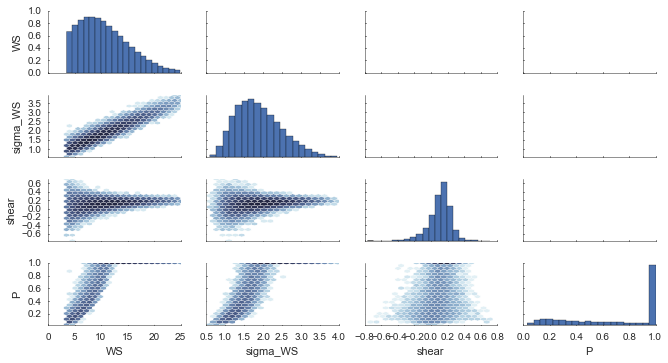

In [525]:
g = sns.PairGrid(df_sample,diag_sharey=False,size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20) 
g.savefig('Figures/8_WindEnergy_'+output_name_label+'_MC_sample.pdf')

### b) PCE point collocation

In [526]:
D = 2
M = 4    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_R)

In [527]:
# Fixed number of model evaluations and Hammersley sequence sampling
nodes_R = dist_R.sample(int(3*special.comb(D+M+1,M+1)),rule='M')
#nodes_R = dist_R.sample(200,rule='M')

# Exponenial rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2**M-1,rule='M')

# Linear rule and Hammersley sequence sampling
#nodes_R = dist_R.sample(2*M-1,rule='M')

print 'nodes', len(nodes_R[0,:])

nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

df_nodes = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = nodes_Q.T)
#df_nodes['TI']=df_nodes.sigma_WS/df_nodes.WS
df_nodes[output_name_label] = sample_u_pc

nodes 63


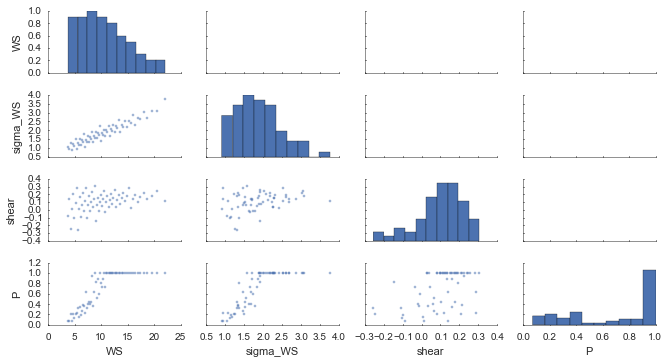

In [528]:
g = sns.PairGrid(df_nodes,diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_nodes.pdf')

35
(1, 0, 0)
(2, 0, 0)
(3, 0, 0)
(4, 0, 0)
(1, 1, 0)
(3, 1, 0)
(0, 1, 0)
(2, 1, 0)
(0, 2, 0)
(1, 2, 0)
(2, 2, 0)
(1, 3, 0)
(0, 3, 0)
(0, 4, 0)
(1, 0, 1)
(2, 0, 1)
(3, 0, 1)
(0, 1, 1)
(1, 1, 1)
(2, 1, 1)
(0, 2, 1)
(1, 2, 1)
(0, 0, 1)
(0, 3, 1)
(1, 0, 2)
(2, 0, 2)
(1, 1, 2)
(0, 1, 2)
(0, 2, 2)
(0, 0, 2)
(1, 0, 3)
(0, 0, 3)
(0, 0, 4)
(0, 0, 0)
(0, 1, 3)


/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


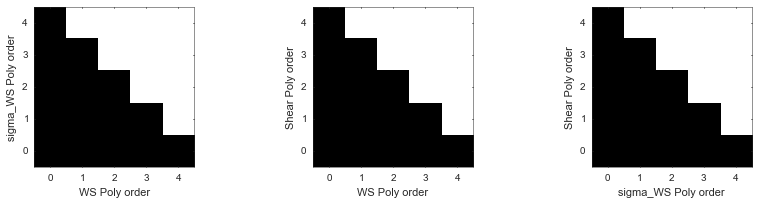

In [529]:
# Point collocation
u_hat = cp.fit_regression(P, nodes_R, sample_u_pc, 
                          #rule='LA',n_nonzero_coefs=100) #Lars (Least Angle Regression). n_nonzero_coefs= all dimensions
                          #rule='LAS',alpha=1e-4,max_iter=200) #Lasso (Least Absolute Shrinkage and Selection Operator) 
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='LL', alpha=1e-5,max_iter=200) #Lasso and Lars model
                          #rule='OMP',n_nonzero_coefs=M+1, tol=1e2) # Orthogonal Matching Pursuit. n_nonzero_coefs=1D
                          # -----------
                          # NOT sparse
                          # -----------
                          #rule='BARD')
                          # -----------
                          # Cross-Validation
                          # -----------
                          #rule="LLC",cv=20)
                          rule="LASC",cv=20, alphas = np.logspace(-8,-1,50))

# Statistics based on the PCE coefficients
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

print len(u_hat.expons())
if len(u_hat.expons())<100:
    for i in range(len(u_hat.expons())):
        print u_hat.expons()[i]#, u_hat.coeffs()[i]

A=np.zeros([M+1]*3)
for i in range(len(u_hat.expons())):
    A[u_hat.expons()[i]]=1.#u_hat.coeffs()[i]
    
fig = plt.figure(figsize=[12,3])
ax = fig.add_subplot(131)
plt.imshow(A[:,:,0].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('sigma_WS Poly order')

ax = fig.add_subplot(132)
plt.imshow(A[:,0,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('WS Poly order')
ax.set_ylabel('Shear Poly order')

ax = fig.add_subplot(133)
plt.imshow(A[0,:,:].T, 
           interpolation='nearest',
           origin='lower'
          )
ax.set_xlabel('sigma_WS Poly order')
ax.set_ylabel('Shear Poly order')

fig.tight_layout()
fig.savefig('Figures/8_WindEnergy_PCE_sparse.pdf')

In [530]:
# Repeat the MC sample ussing the surrogate model
sample_R_inputs = dist_R.sample(size=10**4,rule='H')
sample_Q_inputs = dist_Q.inv(dist_R.fwd(sample_R_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_R_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
# sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

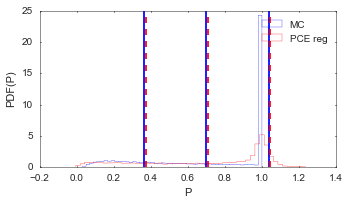

In [531]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.axvline(E_u,color='blue')
ax.axvline(E_u-Std_u,color='blue')
ax.axvline(E_u+Std_u,color='blue')
#ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE reg'
        )
ax.axvline(mean_u_pc,color='red',linestyle='--')
ax.axvline(mean_u_pc-std_u_pc,color='red',linestyle='--')
ax.axvline(mean_u_pc+std_u_pc,color='red',linestyle='--')
#plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel(output_name_label)
ax.set_ylabel('PDF('+output_name_label+')')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_PDF.pdf')
print

In [532]:
df_sample_pc = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_Q_inputs.T)
#df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc[output_name_label] = sample_u_hat

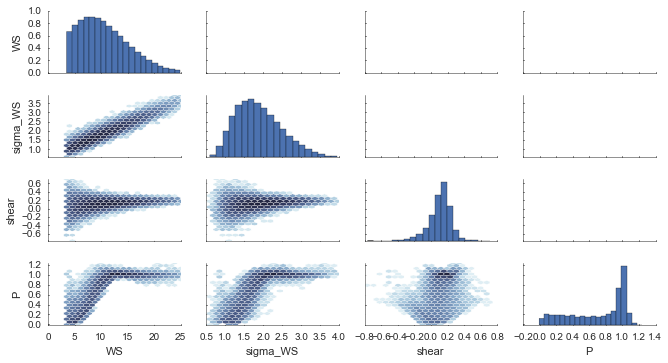

In [533]:
g = sns.PairGrid(df_sample_pc,diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_sample.pdf')

### c) PCE spectral projection

In [534]:
M = 4    # Order of the polynomial
N = M + 1 # Number of terms

P = cp.orth_ttr(M,dist_R)

In [535]:
nodes_R, weights_R = cp.generate_quadrature(M+1, dist_R, rule='G')#, sparse=True)
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 
    
Npc = len(weights_R)

sample_u_train = np.array([model(*node) for node in nodes_Q.T])
u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)

df_nodes_sp = None
df_nodes_sp = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = nodes_Q.T)
#df_nodes_sp['TI']= df_nodes_sp.sigma_WS/df_nodes_sp.WS
df_nodes_sp[output_name_label] = sample_u_train

216


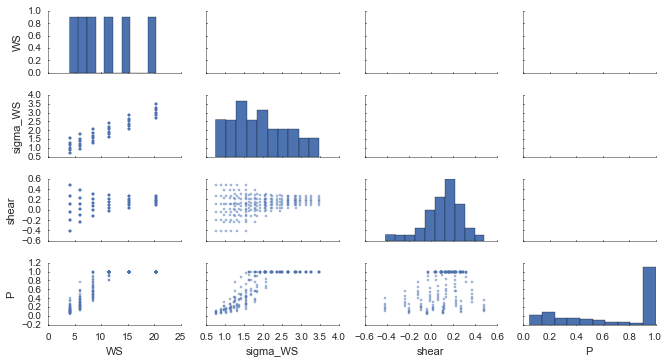

In [536]:
print len(weights_R)

g = sns.PairGrid(df_nodes_sp,diag_sharey=False,size=1.3,aspect=1.8)
g.map_lower(plt.scatter,alpha=0.5, marker='.')#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)        
g.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_nodes_sp.pdf')

In [537]:
# Repeat the MC sample ussing the surrogate model
sample_R_inputs = dist_R.sample(size=10**4,rule='H')
sample_Q_inputs = dist_Q.inv(dist_R.fwd(sample_R_inputs))
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_R_inputs.T ])

# Do NOT truncate the surrogate to show the rated power.
# You will loose the accuracy in E and V
# sample_u_hat = sample_u_hat*(sample_u_hat<=1.)*(sample_u_hat>0.) + 1.*(sample_u_hat>1.)

E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

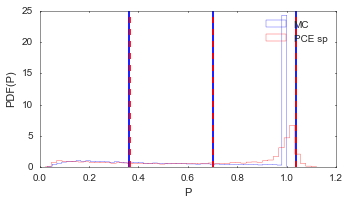

In [538]:
fig = plt.figure(figsize=[5,3])
ax = fig.add_subplot(111)
ax.hist(sample_u,
         bins=50,
         histtype='step',
         color='blue',
         normed=True,
         cumulative=False,
         label='MC'
        )
ax.axvline(E_u,color='blue')
ax.axvline(E_u-Std_u,color='blue')
ax.axvline(E_u+Std_u,color='blue')
#ax.vlines([E_u,E_u-Std_u,E_u+Std_u],0,10,'blue')
#plt.vlines([Q05_u,Q95_u],0,10,'lightblue')

plt.hist(sample_u_hat,
         bins=50,
         histtype='step',
         color='red',
         normed=True,
         cumulative=False,
         label='PCE sp'
        )
ax.axvline(mean_u_pc,color='red',linestyle='--')
ax.axvline(mean_u_pc-std_u_pc,color='red',linestyle='--')
ax.axvline(mean_u_pc+std_u_pc,color='red',linestyle='--')
#plt.vlines([mean_u_pc,mean_u_pc-std_u_pc,mean_u_pc+std_u_pc],0,10,'red','--')
#plt.vlines([Q05_u_hat,Q95_u_hat],0,10,'pink')

ax.set_xlabel(output_name_label)
ax.set_ylabel('PDF('+output_name_label+')')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_PDF_sp.pdf')
print

In [539]:
df_sample_pc = None
df_sample_pc = pd.DataFrame(
    columns=['WS','sigma_WS','shear'],
    data = sample_Q_inputs.T)
#df_sample_pc['TI']=df_sample_pc.sigma_WS/df_sample_pc.WS
df_sample_pc[output_name_label] = sample_u_hat

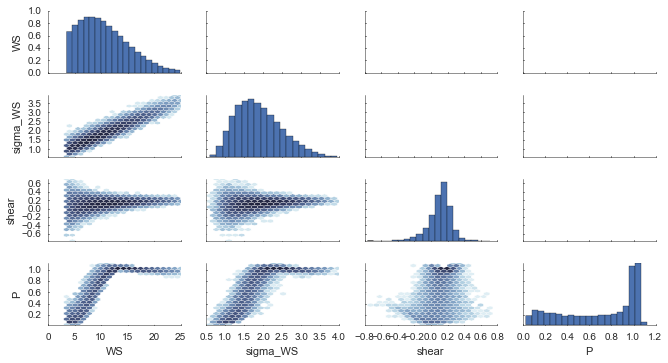

In [540]:
g = sns.PairGrid(df_sample_pc,diag_sharey=False, size=1.3,aspect=1.8)
#g.map_lower(plt.scatter,alpha=0.2)#sns.regplot, fit_reg=True, order=2, x_jitter=.1) #
g.map_lower(plt.hexbin, gridsize=20, bins='log', color='white', cmap=sns.cubehelix_palette(light=1,rot=-.15,as_cmap=True))
#g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist, bins=20)
g.savefig('Figures/8_WindEnergy_'+output_name_label+'_PCE_sample_sp.pdf')

### d) Convergence

In [541]:
#```Python
sample_inputs = dist_Q.sample(size=10**7,rule='H')
sample_u = model(*sample_inputs)

E_u_ref = np.mean(sample_u,axis=0)
Std_u_ref = np.std(sample_u,axis=0)
#```

In [542]:
def PCE(M):
    # M: Order of the polynomial
    D = 3    # Number of dimensions

    P = cp.orth_ttr(M,dist_R)
    # Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
    Npc = int(3*special.comb(D+M+1,M+1)) #2**M-1#
    
    print Npc
    
    nodes_R = dist_R.sample(Npc,rule='M') 
    #nodes_R = pyDOE.lhs(n=D,samples=Npc, criterion='c').T
    
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
    sample_u_pc = np.array([model(*node) for node in nodes_Q.T])

    u_hat = cp.fit_regression(P=P, x=nodes_R, u=sample_u_pc, 
                              #rule="LLC",cv=20)
                              #rule="LAC",cv=20)
                              rule="LASC",cv=20, alphas = np.logspace(-8,-1,50))
                              #rule='LL', alpha=1e-5,max_iter=200)
                              #rule="LA", n_nonzero_coefs=20 )
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    
    Error_E = np.abs(E_u_ref - mean_u_pc)/E_u
    Error_Std = np.abs(std_u_pc**2./Std_u_ref**2. - 1.)
    
    return Npc,Error_E, Error_Std

In [543]:
order = range(2,15)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

60
105

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



168
252

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



360
495

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



660
858

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



1092
1365

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



1680
2040

/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



2448


/Users/JPM/OpenMDAO/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [544]:
def PCE_sp(M):
    # M: Order of the polynomial
    D = 3    # Number of dimensions
    
    P = cp.orth_ttr(M,dist_R)
    nodes_R, weights_R = cp.generate_quadrature(M+1, dist_R, rule='G')
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 

    sample_u_train = np.array([model(*node) for node in nodes_Q.T])
    
    u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)
    Npc = len(weights_R)
    print Npc #len(P)
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    Error_E = np.abs(E_u_ref - mean_u_pc)/E_u
    Error_Std = np.abs(std_u_pc**2./Std_u_ref**2. - 1.)
    
    return Npc,Error_E, Error_Std

In [545]:
order   = range(2,15)
Npc_sp     = np.zeros(len(order))
Error_E_sp = np.zeros(len(order))
Error_Std_sp = np.zeros(len(order))

for i,M in enumerate(order):
    Npc_sp[i],Error_E_sp[i], Error_Std_sp[i] = PCE_sp(M)

64
125
216
343
512
729
1000
1331
1728
2197
2744
3375
4096


In [549]:
def MC(Nmc):
    print Nmc
    sample_inputs = dist_Q.sample(size=Nmc,rule='H')
    sample_u = np.array([model(*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.abs(E_u_ref - E_u_mc)/E_u
    Error_Std_mc = np.abs(Std_u_mc**2./Std_u_ref**2.-1.)
    
    return Error_E_mc, Error_Std_mc

In [550]:
Nmc     = [10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

100
1000
10000
100000


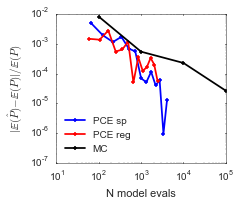

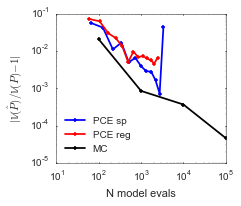

In [551]:
fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc_sp,Error_E_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_E,'.-r',label='PCE reg')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/8_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc_sp,Error_Std_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_Std,'.-r',label='PCE reg')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/8_Convergence_V_'+output_name_label+'.pdf')